In [1]:
import torch
import torch.nn as nn

In [2]:
torch.__version__

'2.0.1+cu117'

In [5]:
#pip install torchtext

In [8]:
#pip install 'portalocker>=2.0.0'

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torchtext
torchtext.__version__

'0.15.2+cpu'

In [2]:
import torch
from torchtext.datasets import AG_NEWS

trainset, testset = AG_NEWS(root='./data', split=('train', 'test'))
train_iter = iter(AG_NEWS(split='train'))

print(next(train_iter)) 
print(len(next(train_iter)[1])) # print the length of the sentence

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
266


In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(trainset), specials=["<unk>"], min_freq=50)
vocab.set_default_index(vocab["<unk>"])

print(vocab(['here', 'is', 'an', 'example']))

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

print(text_pipeline('here is an example'))
print(label_pipeline('4'))

[475, 21, 30, 5297]
[475, 21, 30, 5297]
3


In [4]:
import torch
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        if sequence<10000:
            results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


def collate_batch(batch): 
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = text_pipeline(_text)
         processed_text = torch.tensor(vectorize_sequences(processed_text))
         processed_text = torch.sum(processed_text, dim=0)
         processed_text = torch.where(processed_text>0, torch.ones_like(processed_text), torch.zeros_like(processed_text))
        #  print(torch.tensor(_label).shape, processed_text.shape)
         text_list.append(processed_text.view(-1, 10000))
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    # print(len(text_list))
    text_list = torch.cat(text_list, dim=0).float()
    # print(text_list.shape)
    return label_list.to(device), text_list.to(device)#, offsets.to(device)

train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

split_train_, split_valid_ = \
    random_split(train_dataset, [60000, 60000])

train_dataloader = DataLoader(split_train_, batch_size=128,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=128,
                              shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=128,
                             shuffle=False, collate_fn=collate_batch)

cuda


In [5]:
# NN model design

import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 1024)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 256)
        self.act2 = nn.ReLU()
        # self.fc3 = nn.Linear(256, 256)
        # self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        # x = self.act3(self.fc3(x))
        x = self.fc4(x)

        return x
        
model = Model()
model.to(device)


optimizer = optim.RMSprop(params = model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [6]:
# 학습
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(10):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.399, accuracy: 0.8756, val_loss: 0.281, valid accuracy: 0.9075
[2,   469] loss: 0.184, accuracy: 0.9403, val_loss: 0.312, valid accuracy: 0.9073
[3,   469] loss: 0.077, accuracy: 0.9748, val_loss: 0.461, valid accuracy: 0.9047
[4,   469] loss: 0.042, accuracy: 0.9886, val_loss: 0.610, valid accuracy: 0.8999
[5,   469] loss: 0.031, accuracy: 0.9928, val_loss: 0.672, valid accuracy: 0.9037
[6,   469] loss: 0.024, accuracy: 0.9949, val_loss: 0.916, valid accuracy: 0.8996
[7,   469] loss: 0.023, accuracy: 0.9953, val_loss: 0.975, valid accuracy: 0.9032
[8,   469] loss: 0.022, accuracy: 0.9963, val_loss: 0.898, valid accuracy: 0.8996
[9,   469] loss: 0.018, accuracy: 0.9965, val_loss: 1.126, valid accuracy: 0.8968
[10,   469] loss: 0.023, accuracy: 0.9968, val_loss: 1.205, valid accuracy: 0.8988
Finished Training


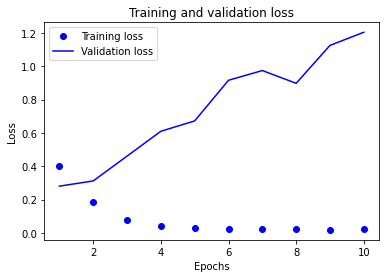

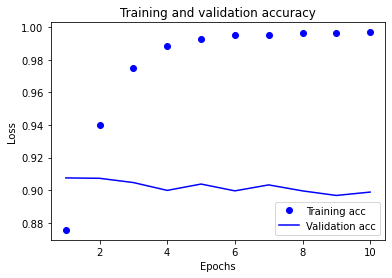

In [7]:
# 시각화

import matplotlib.pyplot as plt

loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc = history['acc']
val_acc = history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
# Test set에서 모델 성능 확인

running_test_loss = 0
running_test_correct = 0
running_test_total = 0


for i, data in enumerate(test_dataloader):
    labels, inputs = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

    running_test_loss += loss.item()
    running_test_correct += (preds == labels).sum()          
    running_test_total += labels.size(0)

print(f'test loss: {running_loss / len(test_dataloader):.3f}, test accuracy: {running_test_correct/running_test_total:.4f}')

test loss: 0.178, test accuracy: 0.8967


In [9]:

data = next(iter(test_dataloader))
labels, inputs = data
inputs = inputs.to(device)
labels = labels.to(device)

predictions = model(inputs)
print(predictions[0], predictions[0].shape)
softmax_predictions = torch.softmax(predictions, dim=1)
print(softmax_predictions[0], softmax_predictions[0].shape)

tensor([ -7.9926, -20.9566,  15.2954,  -9.7159], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([4])
tensor([7.6940e-11, 1.8029e-16, 1.0000e+00, 1.3732e-11], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([4])


### On the importance of having sufficiently large intermediate layers

In [10]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 4)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(4, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)

        return x
        
model = Model()
model.to(device)


optimizer = optim.RMSprop(params = model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(10):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.427, accuracy: 0.8582, val_loss: 0.321, valid accuracy: 0.8990
[2,   469] loss: 0.232, accuracy: 0.9256, val_loss: 0.342, valid accuracy: 0.8987
[3,   469] loss: 0.155, accuracy: 0.9510, val_loss: 0.397, valid accuracy: 0.8918
[4,   469] loss: 0.105, accuracy: 0.9692, val_loss: 0.526, valid accuracy: 0.8895
[5,   469] loss: 0.078, accuracy: 0.9787, val_loss: 0.658, valid accuracy: 0.8854
[6,   469] loss: 0.063, accuracy: 0.9835, val_loss: 0.812, valid accuracy: 0.8870
[7,   469] loss: 0.054, accuracy: 0.9865, val_loss: 0.828, valid accuracy: 0.8844
[8,   469] loss: 0.051, accuracy: 0.9876, val_loss: 0.846, valid accuracy: 0.8807
[9,   469] loss: 0.048, accuracy: 0.9884, val_loss: 0.888, valid accuracy: 0.8813
[10,   469] loss: 0.049, accuracy: 0.9875, val_loss: 0.879, valid accuracy: 0.8796
Finished Training


결과적으로 unit 숫자를 충분히 늘리지 않으면 일반화 성능이 떨어지는 것을 확인할 수 있었다.
또한, 기본 학습에서도 정확도가 99%를 넘기기 힘들어 한다. 

As a result, we can see that generalization performance decreases if the number of units is not increased enough.
Furthermore, even with basic training, the accuracy rate struggles to exceed 99%.

## 성능 올려보기
학습하는데에 시간이 많이 걸리기에 적은 test로 성능 올려보자

### 1. optimizer: adam. 일반적으로 adam이 최적화 성능이 좋다고 알려져 있다.
### 2. Dropout을 추가하여 과적합 방지
### 3. BatchNormalization 
### 4. layer 수를 늘리기(one more layer) + unit increase


In [12]:
# NN model design

import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 1024)
        self.act1 = nn.ReLU()
        self.BatchNorm1d1 = nn.BatchNorm1d(1024, affine=False) # Batch Normalization 추가
        self.drop1 = nn.Dropout(0.3) # Dropout 추가
        
        self.fc2 = nn.Linear(1024, 256)
        self.act2 = nn.ReLU()
        self.BatchNorm1d2 = nn.BatchNorm1d(256, affine=False) # Batch Normalization 추가
        self.drop2 = nn.Dropout(0.3) # Dropout 추가
        
        self.fc3 = nn.Linear(256, 256)
        self.act3 = nn.ReLU()
        self.BatchNorm1d3 = nn.BatchNorm1d(256, affine=False) # Batch Normalization 추가
        
        self.fc4 = nn.Linear(256, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.drop1(self.BatchNorm1d1(self.act1(self.fc1(x))))
        x = self.drop2(self.BatchNorm1d2(self.act2(self.fc2(x))))
        x = self.BatchNorm1d3(self.act3(self.fc3(x)))
        x = self.fc4(x)

        return x
        
model = Model()
model.to(device)

# 하이퍼파라미터 설정
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss() # 다중분류에서는 CrossEntropyLoss를 사용하는 것이 일반적

In [13]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(10):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.342, accuracy: 0.8808, val_loss: 0.285, valid accuracy: 0.9027
[2,   469] loss: 0.165, accuracy: 0.9406, val_loss: 0.329, valid accuracy: 0.8974
[3,   469] loss: 0.090, accuracy: 0.9670, val_loss: 0.368, valid accuracy: 0.8968
[4,   469] loss: 0.060, accuracy: 0.9781, val_loss: 0.432, valid accuracy: 0.8962
[5,   469] loss: 0.045, accuracy: 0.9842, val_loss: 0.468, valid accuracy: 0.8945
[6,   469] loss: 0.039, accuracy: 0.9860, val_loss: 0.483, valid accuracy: 0.8988
[7,   469] loss: 0.033, accuracy: 0.9880, val_loss: 0.497, valid accuracy: 0.8983
[8,   469] loss: 0.028, accuracy: 0.9898, val_loss: 0.536, valid accuracy: 0.8957
[9,   469] loss: 0.025, accuracy: 0.9914, val_loss: 0.539, valid accuracy: 0.8966
[10,   469] loss: 0.024, accuracy: 0.9924, val_loss: 0.548, valid accuracy: 0.8991
Finished Training


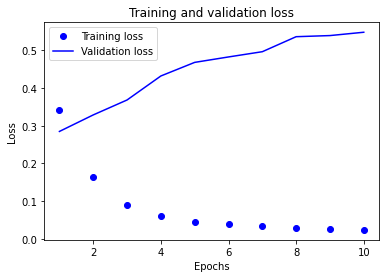

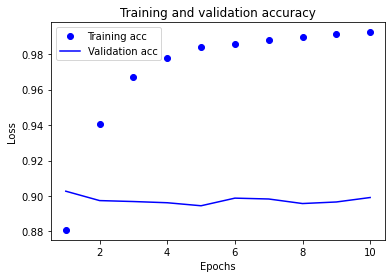

In [14]:
# 시각화

import matplotlib.pyplot as plt

loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc = history['acc']
val_acc = history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
# Test set에서 모델 성능 확인

running_test_loss = 0
running_test_correct = 0
running_test_total = 0


for i, data in enumerate(test_dataloader):
    labels, inputs = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

    running_test_loss += loss.item()
    running_test_correct += (preds == labels).sum()          
    running_test_total += labels.size(0)

print(f'test loss: {running_loss / len(test_dataloader):.3f}, test accuracy: {running_test_correct/running_test_total:.4f}')

test loss: 0.184, test accuracy: 0.8897


예상한 것보다 성능이 변하지 않는다. 수치를 더 조절해야 할 것 같다. dropout 수치를 조절

In [17]:
# NN model design

import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 1024)
        self.act1 = nn.ReLU()
        self.BatchNorm1d1 = nn.BatchNorm1d(1024, affine=False) # Batch Normalization 추가
        self.drop1 = nn.Dropout(0.25) # Dropout 추가
        
        self.fc2 = nn.Linear(1024, 256)
        self.act2 = nn.ReLU()
        self.BatchNorm1d2 = nn.BatchNorm1d(256, affine=False) # Batch Normalization 추가
        self.drop2 = nn.Dropout(0.25) # Dropout 추가
        
        self.fc3 = nn.Linear(256, 256)
        self.act3 = nn.ReLU()
        self.BatchNorm1d3 = nn.BatchNorm1d(256, affine=False) # Batch Normalization 추가
        
        self.fc4 = nn.Linear(256, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.drop1(self.BatchNorm1d1(self.act1(self.fc1(x))))
        x = self.drop2(self.BatchNorm1d2(self.act2(self.fc2(x))))
        x = self.BatchNorm1d3(self.act3(self.fc3(x)))
        x = self.fc4(x)

        return x
        
model = Model()
model.to(device)

# 하이퍼파라미터 설정
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss() # 다중분류에서는 CrossEntropyLoss를 사용하는 것이 일반적

In [18]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(10):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.338, accuracy: 0.8818, val_loss: 0.286, valid accuracy: 0.9025
[2,   469] loss: 0.159, accuracy: 0.9430, val_loss: 0.308, valid accuracy: 0.9006
[3,   469] loss: 0.081, accuracy: 0.9711, val_loss: 0.386, valid accuracy: 0.8972
[4,   469] loss: 0.055, accuracy: 0.9798, val_loss: 0.455, valid accuracy: 0.8970
[5,   469] loss: 0.043, accuracy: 0.9849, val_loss: 0.458, valid accuracy: 0.8983
[6,   469] loss: 0.033, accuracy: 0.9884, val_loss: 0.489, valid accuracy: 0.8972
[7,   469] loss: 0.027, accuracy: 0.9900, val_loss: 0.561, valid accuracy: 0.8983
[8,   469] loss: 0.029, accuracy: 0.9898, val_loss: 0.543, valid accuracy: 0.8990
[9,   469] loss: 0.026, accuracy: 0.9909, val_loss: 0.538, valid accuracy: 0.8960
[10,   469] loss: 0.023, accuracy: 0.9918, val_loss: 0.576, valid accuracy: 0.8979
Finished Training


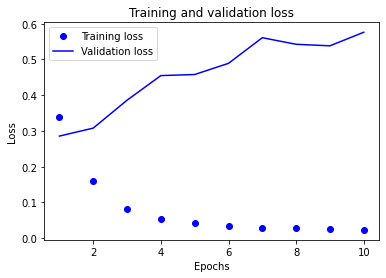

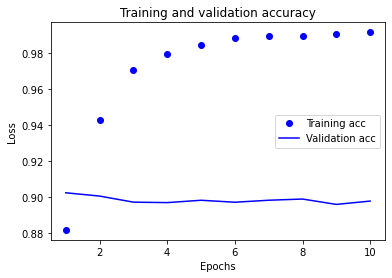

In [19]:
# 시각화

import matplotlib.pyplot as plt

loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

acc = history['acc']
val_acc = history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
# Test set에서 모델 성능 확인

running_test_loss = 0
running_test_correct = 0
running_test_total = 0


for i, data in enumerate(test_dataloader):
    labels, inputs = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

    running_test_loss += loss.item()
    running_test_correct += (preds == labels).sum()          
    running_test_total += labels.size(0)

print(f'test loss: {running_loss / len(test_dataloader):.3f}, test accuracy: {running_test_correct/running_test_total:.4f}')

test loss: 0.181, test accuracy: 0.8911


지금도 성능 변화는 없는 것 같음. 안정적인 학습은 가능한 것 같음. dropout의 효과가 미미한 것으로 판단. 삭제후 다른 부분을 조정

In [21]:
# NN model design
# dropout을 삭제 후 Batch Normalization만 사용

import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 1024)
        self.act1 = nn.ReLU()
        self.BatchNorm1d1 = nn.BatchNorm1d(1024, affine=False) # Batch Normalization 추가
        
        self.fc2 = nn.Linear(1024, 256)
        self.act2 = nn.ReLU()
        self.BatchNorm1d2 = nn.BatchNorm1d(256, affine=False) # Batch Normalization 추가
        
        self.fc3 = nn.Linear(256, 64)
        self.act3 = nn.ReLU()
        self.BatchNorm1d3 = nn.BatchNorm1d(256, affine=False) # Batch Normalization 추가
        
        self.fc4 = nn.Linear(64, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.BatchNorm1d1(self.act1(self.fc1(x)))
        x = self.BatchNorm1d2(self.act2(self.fc2(x)))
        x = self.BatchNorm1d3(self.act3(self.fc3(x)))
        x = self.fc4(x)

        return x
        
model = Model()
model.to(device)

# 하이퍼파라미터 설정
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss() # 다중분류에서는 CrossEntropyLoss를 사용하는 것이 일반적

In [22]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(10):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.333, accuracy: 0.8842, val_loss: 0.280, valid accuracy: 0.9030
[2,   469] loss: 0.139, accuracy: 0.9503, val_loss: 0.319, valid accuracy: 0.8983
[3,   469] loss: 0.062, accuracy: 0.9779, val_loss: 0.398, valid accuracy: 0.8982
[4,   469] loss: 0.038, accuracy: 0.9865, val_loss: 0.470, valid accuracy: 0.8980
[5,   469] loss: 0.032, accuracy: 0.9891, val_loss: 0.487, valid accuracy: 0.8986
[6,   469] loss: 0.024, accuracy: 0.9915, val_loss: 0.527, valid accuracy: 0.8962
[7,   469] loss: 0.023, accuracy: 0.9918, val_loss: 0.571, valid accuracy: 0.8949
[8,   469] loss: 0.021, accuracy: 0.9927, val_loss: 0.577, valid accuracy: 0.8995
[9,   469] loss: 0.021, accuracy: 0.9925, val_loss: 0.569, valid accuracy: 0.8999
[10,   469] loss: 0.017, accuracy: 0.9941, val_loss: 0.555, valid accuracy: 0.8975
Finished Training


In [23]:
# Test set에서 모델 성능 확인

running_test_loss = 0
running_test_correct = 0
running_test_total = 0


for i, data in enumerate(test_dataloader):
    labels, inputs = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

    running_test_loss += loss.item()
    running_test_correct += (preds == labels).sum()          
    running_test_total += labels.size(0)

print(f'test loss: {running_loss / len(test_dataloader):.3f}, test accuracy: {running_test_correct/running_test_total:.4f}')

test loss: 0.131, test accuracy: 0.8928


층과 unit의 값을 더 세밀하게 조정해보자

In [26]:
# NN model design
# 층을 하나 더 추가하고 unit을 변경

import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 5120)
        self.act1 = nn.ReLU()
        self.BatchNorm1d1 = nn.BatchNorm1d(5120, affine=False) # Batch Normalization 추가
        
        self.fc2 = nn.Linear(5120, 1024)
        self.act2 = nn.ReLU()
        self.BatchNorm1d2 = nn.BatchNorm1d(1024, affine=False) # Batch Normalization 추가
        
        self.fc3 = nn.Linear(1024, 256)
        self.act3 = nn.ReLU()
        self.BatchNorm1d3 = nn.BatchNorm1d(256, affine=False) # Batch Normalization 추가

        self.fc4 = nn.Linear(256, 64)
        self.act4 = nn.ReLU()
        self.BatchNorm1d4 = nn.BatchNorm1d(64, affine=False) # Batch Normalization 추가
        
        self.fc5 = nn.Linear(64, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch



    def forward(self, x):
        x = self.BatchNorm1d1(self.act1(self.fc1(x)))
        x = self.BatchNorm1d2(self.act2(self.fc2(x)))
        x = self.BatchNorm1d3(self.act3(self.fc3(x)))
        x = self.BatchNorm1d4(self.act4(self.fc4(x)))
        x = self.fc5(x)

        return x
        
model = Model()
model.to(device)

# 하이퍼파라미터 설정
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss() # 다중분류에서는 CrossEntropyLoss를 사용하는 것이 일반적

In [27]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(10):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.337, accuracy: 0.8842, val_loss: 0.289, valid accuracy: 0.8997
[2,   469] loss: 0.142, accuracy: 0.9496, val_loss: 0.311, valid accuracy: 0.9008
[3,   469] loss: 0.063, accuracy: 0.9782, val_loss: 0.390, valid accuracy: 0.9012
[4,   469] loss: 0.039, accuracy: 0.9863, val_loss: 0.447, valid accuracy: 0.8975
[5,   469] loss: 0.033, accuracy: 0.9886, val_loss: 0.480, valid accuracy: 0.8988
[6,   469] loss: 0.028, accuracy: 0.9904, val_loss: 0.492, valid accuracy: 0.8972
[7,   469] loss: 0.024, accuracy: 0.9917, val_loss: 0.495, valid accuracy: 0.9005
[8,   469] loss: 0.021, accuracy: 0.9927, val_loss: 0.495, valid accuracy: 0.8991
[9,   469] loss: 0.017, accuracy: 0.9939, val_loss: 0.535, valid accuracy: 0.8998
[10,   469] loss: 0.017, accuracy: 0.9943, val_loss: 0.528, valid accuracy: 0.9019
Finished Training


In [28]:
# Test set에서 모델 성능 확인

running_test_loss = 0
running_test_correct = 0
running_test_total = 0


for i, data in enumerate(test_dataloader):
    labels, inputs = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

    running_test_loss += loss.item()
    running_test_correct += (preds == labels).sum()          
    running_test_total += labels.size(0)

print(f'test loss: {running_loss / len(test_dataloader):.3f}, test accuracy: {running_test_correct/running_test_total:.4f}')

test loss: 0.135, test accuracy: 0.8971


드디어 baseline을 넘어서는 모델을 만들었다. 
batchnormalization 이나 dropout을 쓰는 것보다 layer 수와 unit을 적절하게 설정하는 것이 더 중요한 것 같다.